# Восстановление золота из руды

В нашем распоряжении данные золотодобывающей компании. 
Необходимо разработать модель машинного обучения, которая сможет прогнозировать успешность восстановления золота из руды, исходя из имеющихся данных, чтобы в дальнейшем искать точки оптимизации бизнеса. 
План работ: 
1. Выполнить предобработку данных
2. Выполнить статистический анализ
3. Спроектировать модель машинного обучения. 

# Предобработка данных

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
data = pd.read_csv('/datasets/gold_recovery_full_new.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test_new.csv')
train_data = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [3]:
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

In [4]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

In [5]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

Найдем колонки, недоступные в тестовых данных

In [6]:
columns_for_deleting = []
for i in train_data.columns:
    if i not in test_data.columns:
        columns_for_deleting.append(i)

В тестовых данных не хватает выходных признаков для всех стадий обработки руды, а также расчетных характеристик для процесса флотации. 

Если я правильно понимаю условия задачи, то когда в реальных условиях будет работать модель, этих признаков тоже не будет.

План:
1. Добавим в тестовый датасет целевые признаки, которые смерджим из общего датасета по дате.
2. Обучим модель на данных из обучающего датасета без отсутсвующих колонок

Изменим тип данных в колонке `date`

In [7]:
data['date'] = pd.to_datetime(data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data['date'] = pd.to_datetime(train_data['date'])

Смерджим недостающие колонки.

In [8]:
test_data = pd.merge_asof(
    test_data.sort_values(by='date'),
    data[['date', 'rougher.output.recovery', 'final.output.recovery']].sort_values(by='date'),
    on = 'date'
)

Заполним пропущенные значения случайными числами.

In [9]:
def filling_nas(df):
    for i in df:
        try:
            df[i] = df[i].fillna(
        np.random.randint(df[i].min(), df[i].max())
        )
        except:
            pass
    return df
data = filling_nas(data)
train_data = filling_nas(train_data)
test_data = filling_nas(test_data)

Проверим, верно ли рассчитана метрика `recovery` для обучающей выборки.

In [10]:
c = train_data['rougher.output.concentrate_au']
f = train_data['rougher.input.feed_au']
t = train_data['rougher.output.tail_au']

recovery = (c*(f-t))/(f*(c-t))*100
print ('значение MAE составляет', mean_absolute_error(train_data['rougher.output.recovery'], recovery))
all(round(recovery) == round(train_data['rougher.output.recovery']))

значение MAE составляет 9.73512347450521e-15


True

### Вывод
Метрика recovery для стадии флотации рассчитана верно, с точностью до одного процента.

### Подготовка данных для обучения
1. Разделим фреймы по признакам на целевые - target и нецелевые - features
2. Разделим тренировочную выборку на обучающую и валидационную в пропорциях 3:1. 
3. Выполним масштабирование признаков. 

In [11]:
columns_for_deleting.append('date')
columns_for_deleting.append('rougher.output.recovery') 
columns_for_deleting.append('final.output.recovery')
features_train = train_data.drop(columns = columns_for_deleting)
target_train = train_data['final.output.recovery']
target_rougher_train = train_data['rougher.output.recovery']


features_test = test_data.drop(columns = ['date', 'rougher.output.recovery', 'final.output.recovery'])
target_test = test_data['final.output.recovery']
target_rougher_test = test_data['rougher.output.recovery']

In [12]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size = 0.25, random_state=12345)
target_rougher_train, target_rougher_valid = train_test_split(target_rougher_train, test_size = 0.25, random_state=12345)
print ('Размер тренировочной выборки:',features_train.shape)
print ('Размер валидационной выборки:',features_valid.shape)

Размер тренировочной выборки: (10611, 52)
Размер валидационной выборки: (3538, 52)


Данные подготовлены.

## Анализ данных

Исследуем, как менялась концентрация веществ (au, ag, pb) в зависимости от стадии обработки сырья. 

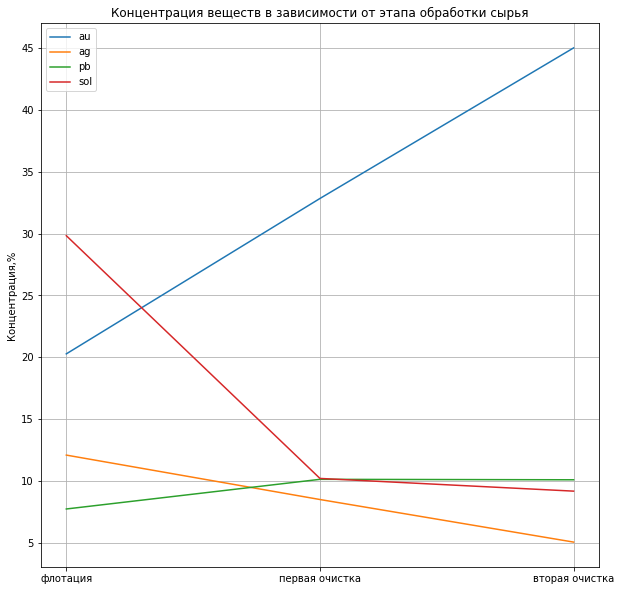

In [13]:
stadies = ['флотация', 'первая очистка', 'вторая очистка']

au = data[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].median()
pb = data[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].median()
ag = data[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].median()
sol = data[['rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']].median()



plt.figure(figsize = (10,10))
plt.title('Концентрация веществ в зависимости от этапа обработки сырья')
plt.grid()
plt.ylabel('Концентрация,%')
plt.plot(stadies, au)
plt.plot(stadies, ag)
plt.plot(stadies, pb)
plt.plot(stadies, sol)
plt.legend(['au', 'ag', 'pb', 'sol'])
plt.show()

Отметим, что возрастает концентрация золота на каждой стадии процесса. 
Заметно снижается уровень соли(?) после флотации.
Серебро и свинец меняются незначительно. 

Исследуем изменение суммарных концентраций веществ в зависимости от стадии обработки сырья.

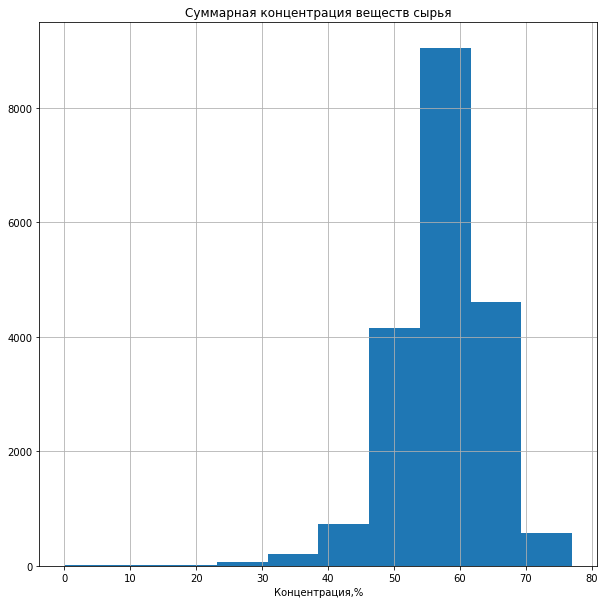

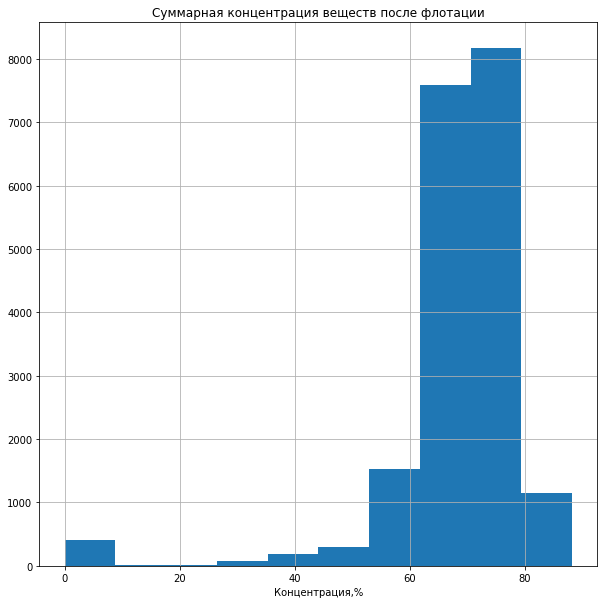

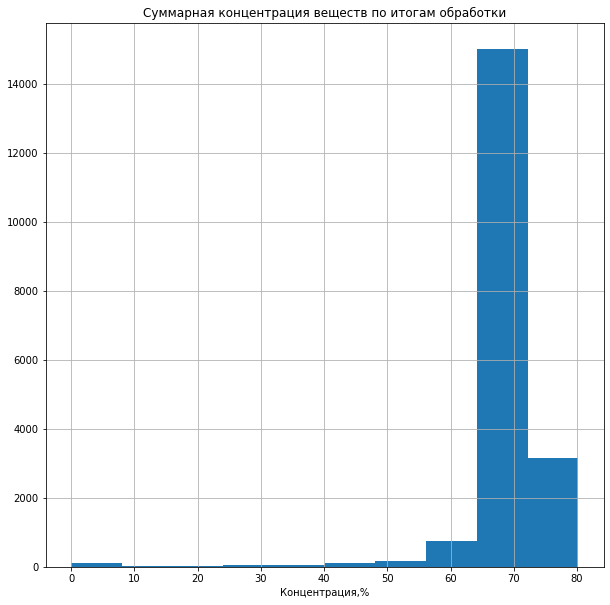

In [14]:
plt.figure(figsize = (10,10))
plt.title('Суммарная концентрация веществ сырья')
plt.grid()
plt.xlabel('Концентрация,%')
plt.hist(data['rougher.input.feed_au'] +
    data['rougher.input.feed_ag'] +
    data['rougher.input.feed_pb'] +
    data['rougher.input.feed_sol'])
plt.show()



plt.figure(figsize = (10,10))
plt.title('Суммарная концентрация веществ после флотации')
plt.grid()
plt.xlabel('Концентрация,%')
plt.hist(data['rougher.output.concentrate_au']+
    data['rougher.output.concentrate_ag']+
    data['rougher.output.concentrate_pb']+
    data['rougher.output.concentrate_sol'])
plt.show()


plt.figure(figsize = (10,10))
plt.title('Суммарная концентрация веществ по итогам обработки')
plt.grid()
plt.xlabel('Концентрация,%')
plt.hist(data['final.output.concentrate_au'] +
    data['final.output.concentrate_ag'] +
    data['final.output.concentrate_pb'] +
    data['final.output.concentrate_sol'])
plt.show()

Из графика видим, что суммарная концентрация веществ падает с 70 до 62 по итогам первой ступени очистки, и повышается до 68 после второго этапа очистки. 

Сравним значения размеров гранул в тестовой и обучающей выборках. 

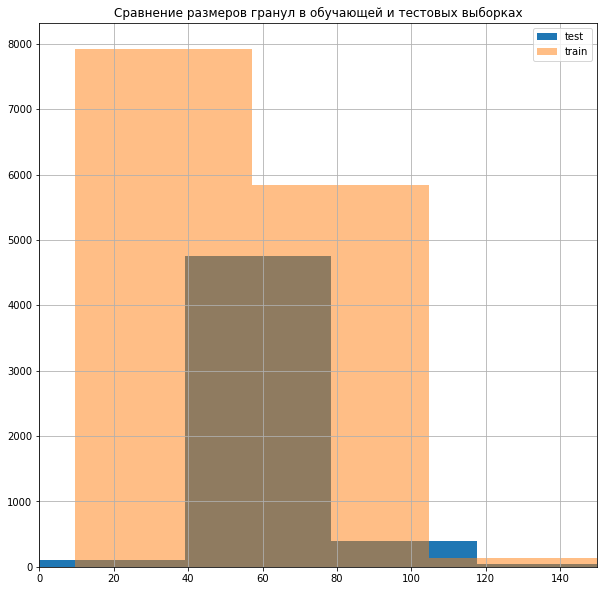

In [15]:
plt.figure(figsize = (10,10))
plt.title('Сравнение размеров гранул в обучающей и тестовых выборках')
plt.grid()
plt.hist(test_data['rougher.input.feed_size'])
plt.hist(train_data['rougher.input.feed_size'], alpha=0.5)
plt.xlim(0,150)
plt.legend(['test', 'train'])
plt.show()

Из графика видно, что размер гранул в обучающей и тестовых выборках находятся преимущественно в диапазоне 40-60. 

Видим, что концентрация золота в руде растет с 20 до 45 процентов при прохождении сырья по стадиям. 
Концентрация солей(?) значительно падает после флотации, с 27 до 10 процентов. 
Концентрация серебра и свинца меняется незначительно.

## Обучение моделей

Задача представлет из себя задачу регрессии. 
Рассмотрим в качестве моделей рассмотрим LogisticRegression, RandomForestRegressor, Decision Tree Regression. 
Сравнивать их будем метрикой sMAPE

Напишем функцию, рассчитывающую значение sMAPE по корректным данным и данным, предсказанным моделью. 

In [16]:
# Функция расчета sMAPE. y - настоящие значения, y_y - предсказанные моделью.
def sMAPE (y, y_y):
    total_sum = 0
    diff = abs(y - y_y)
    summ = ((abs(y)+abs(y_y))/2)
    div = diff/summ
    total_sum = sum(div) #.fillna(0))
    smape = total_sum/len(y)*100
    return smape

In [17]:
smape_scorer = make_scorer(sMAPE)

Рассмотрим различные модели регрессии и выберем наиболее подходящую с помощью кросс-валидации. 
Выбор осуществим с помощью кросс-валидации, используя метрику r2. 


Время выполнения работ моделью оставим вне фокуса внимания, так как модель, разрабатываемая в рамках проекта будет работать не с конечными клиентами, а для внутренних задач.

In [18]:
model = RandomForestRegressor(random_state=12345)
scores = cross_val_score(model, features_train,target_train,scoring = smape_scorer, cv = 5)
print(scores.mean())

7.046064179586902


In [19]:
model = LinearRegression()
scores = cross_val_score(model, features_train,target_rougher_train, scoring = smape_scorer, cv = 5)
print(scores.mean())

9.754121506716322


In [187]:
model = DecisionTreeRegressor(random_state=12345)
scores = cross_val_score(model, features_train,target_rougher_train, scoring = smape_scorer, cv = 10)
print(scores.mean())

7.709169798765592


Лучший результат в кросс-валидации дает модель RandomForestRegressor.

Рассчитаем sMAPE для финального этапа и флотации.

In [188]:
model = RandomForestRegressor(random_state=12345)
model.fit(features_train, target_train)
predicted_values = model.predict(features_test)
predicted_values = pd.Series(index = target_test.index, 
                            data = predicted_values)
smape_final = sMAPE(target_test, predicted_values)

In [189]:
smape_final

9.706716353273567

In [206]:
model = DecisionTreeRegressor(random_state=12345, max_depth=4)
model.fit(features_train, target_rougher_train)
predicted_values = model.predict(features_test)
predicted_values = pd.Series(index = target_rougher_test.index, 
                            data = predicted_values)
smape_rougher = sMAPE(target_rougher_test, predicted_values)

In [207]:
smape_rougher

10.6828236853316

Рассчитаем итоговый sMAPE

In [208]:
smape_total = 0.25*smape_rougher + 0.75*smape_final
smape_total

9.950743186288076

Итоговый sMAPE составли 9,9

In [193]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
predicted_values = model_dummy.predict(features_test)
smape_final_dummy = sMAPE(target_test, predicted_values)
smape_final_dummy

10.310671182083752

In [194]:
model_dummy.fit(features_train, target_rougher_train)
predicted_values = model_dummy.predict(features_test)
smape_rougher_dummy = sMAPE(target_rougher_test, predicted_values)
smape_rougher_dummy

10.280432924419216

In [195]:
smape_total_dummy = 0.75*smape_final_dummy + 0.25*smape_rougher_dummy
smape_total_dummy

10.303111617667618

sMAPE в dummy > sMAPE модели.

## Выводы
#### Предобработка данных
В нашем распоряжении оказались данные по 15 000 записей истории обработки золотой руды, разделенные на обучающую и тестовую выборки. 
В тестовой выборке отсутсвовали целевые признаки и выходные признаки сырья для каждого из этапов производства.
Также, в ряде колонок не хватало значений. 
Предпринятые действия: 
1. Пропуски заполнены случайными значениями. 
2. Из обучающей выборки удалены колонки, отсутствующие в тестовой выборке, чтобы модель училась на том же объеме данных, на котором будет далее делать предсказания. 
3. В тестовую выборку добавлены целевые признаки, взятые из основной выборке по дате.

#### Обучение моделей
В качетсве решения задачи регресси были рассмотрены следующие модели: 
1. RandomForestRegressor
2. DecisionTreeRegressor
3. LinearRegression
Лучшие результаты на обучающей выборке показала модель RandomForestRegressor. При этом, данная модель занимает больше времени, чем остальные, но с учетом того, что пользоваться результатом модели будет не конечный пользователь - выбрали данную модель. 